**Class 4: Deep Q Networks.**

1. <a href="#sec1">Environments</a>
    1. <a href="#sec1.1">Cartpole</a>
    2. <a href="#sec1.2">Cartpole swing-up</a>
    3. <a href="#sec1.3">Pong</a>
2. <a href="#sec2">Value Iteration as a sequence of Supervized Learning problems</a>
3. <a href="#sec3">Experience Replay</a>
4. <a href="#sec4">A deep Q-network</a>
5. <a href="#sec5">Making DQN more efficient</a>
    1. <a href="#sec5.1">Changing the optimizer
    2. <a href="#sec5.2">Several gradient steps
    3. <a href="#sec5.3">Target network</a>
    4. <a href="#sec5.4">Error clipping</a>
6. <a href="#sec6">Metrics</a>
7. <a href="#sec7">DQN on image-based tasks</a>
8. <a href="#sec8">Going further</a>

Let's start with this quote:

> The idea that we learn by interacting with our environment is probably the first to occur to us when we think about the nature of learning. When an infant plays, waves its arms, or looks about, it has no explicit teacher, but it does have a direct sensorimotor connection to its environment. Exercising this connection produces a wealth of information about cause and effect, about the consequences of actions, and about what to do in order to achieve goals. Throughout our lives, such interactions are undoubtedly a major source of knowledge about our environment and ourselves. Whether we are learning to drive a car or to hold a conversation, we are acutely aware of how our environment responds to what we do, and we seek to influence what happens through our behavior. Learning from interaction is a foundational idea underlying nearly all theories of learning and intelligence. (Richard S. Sutton)

# <a id="sec1"></a> Environments

In this session, we will work with three different environments:
- CartPole
- A modified version of CartPole
- Pong

In [0]:
import gym
from gym import logger
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
logger.set_level(gym.logger.DISABLED)

## <a id=sec1.3></a>Pong

Let's build an agent that learns to play Pong, one of the [Atari games](https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py) in Gym (originally in the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment)). You might want to try different games later on (like the popular Breakout game for instance).

In [0]:
pong = gym.make('Pong-v4')

Here is the environment's description.
> Maximize your score in the Atari 2600 game Pong. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). Each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from $\{2, 3, 4\}$.

In [6]:
print(pong.observation_space)
print(pong.observation_space.shape)
print(np.min(pong.observation_space.low))
print(np.max(pong.observation_space.high))
print(pong.action_space)
#help(env.observation_space)

Box(210, 160, 3)
(210, 160, 3)
0
255
Discrete(6)


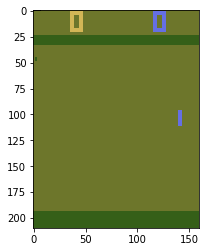

In [7]:
x = pong.reset()
plt.imshow(x)
plt.show()

<div class="alert alert-warning">

**Exercice:** What is the number of possible states? Why is this not an MDP? What would one need to turn this back into an MDP?
</div>

<div class="alert alert-danger">
    <a href="#Pong-theory" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="Pong-theory" class="collapse">

One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Of course, most of the possible images will never occur in a Breakout game and the true state space is actually a much smaller subset of the full set of possible images. Nevertheless, unless we provide a large engineering effort in describing the state space with few variables (which would be contradictory of our goal of a "human-level" AI) we will need to automatically discover some structure in the state sampled data.

This is not an MDP because the transition dynamics do not respect Markov's property. The probability of transitioning from $s_t$ to $s_{t+1}$ is *not* independent of previous states. The problem here is that a single frame of the game does not reflect the velocity of the ball.

To recover Markov's property one could simply stack a few frames together in the state space.
</div>
</div>

There are 18 buttons on the Atari controller. However not all games use all buttons. Our interface to Pong specifies 6 possible actions:
- 0 NOOP (no operation)
- 1 FIRE (press fire button, doesn't do anything in Pong)
- 2 RIGHT (actually moves the paddle up in Pong)
- 3 LEFT (actually moves the paddle left in Pong)
- 4 UP (moves the paddle upwards)
- 5 DOWN (moves the paddle downwards)

The available actions in Pong go up to the 6th action for naming consistency (UP and DOWN), but the four first actions are not really useful.

Also, for an unknown reason, the game does not start until the 20th frame (but always starts automatically, pressing FIRE does not change anything).

The frame rate is 60Hz.

To avoid confusion between the 6 actions allowed by Gym, let's build a wrapper around our environment, with only 2 possible actions ("0" for UP and "1" for DOWN) and a downscaled observation space. Unless you're curious and want to dig in the code, you can simply run the following cells and just use the resulting environment.

In [0]:
from gym.wrappers import AtariPreprocessing
import cv2

class PongWrapper(AtariPreprocessing):
    def __init__(self, env, **kwargs):
        super(PongWrapper, self).__init__(env, **kwargs)

    def step(self, action):
        return super(PongWrapper, self).step(4 + action)

    def _get_obs(self):
        if self.frame_skip > 1:  # more efficient in-place pooling
            np.maximum(self.obs_buffer[0], self.obs_buffer[1], out=self.obs_buffer[0])
        obs = cv2.resize(self.obs_buffer[0], (84, 110), interpolation=cv2.INTER_AREA)[17:101,:]

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        else:
            obs = np.asarray(obs, dtype=np.uint8)
        return obs

In [0]:
pong = PongWrapper(gym.make('PongNoFrameskip-v4'),
                   noop_max=0,
                   frame_skip=4,
                   terminal_on_life_loss=True,
                   grayscale_obs=True,
                   scale_obs=True)

# <a id=sec3></a>Experience Replay

To recover the independence assumption between samples, we can introduce the mechanism of [*Experience Replay*](http://www.incompleteideas.net/lin-92.pdf) by storing past samples into a *Replay Memory*. When samples a required for a mini-batch gradient update, the samples are collected uniformly from the replay memory, thus mimicking an (almost) independent draw according to $\rho(\cdot)$.

<div class="alert alert-warning">
    
**Exercice:** design a class for the replay memory of the cart-pole example(s). Limit the size of this memory (via a FIFO mechanism) to $10^6$ samples (adapt this number to your computer's RAM). Test it by running a random policy for $2\cdot 10^6$ time steps.
</div>

In [0]:
# YOUR REPLAY BUFFER CODE

In [0]:
# It will actually be useful to have separate torch.Tensor for the each element type in the sampled minibatch.
# That is one Tensor for a minibatch of states, another for actions, etc.
# Let's redefine the sample function of our replay buffer class to that end.
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(x).to(device), list(zip(*batch))))

    def __len__(self):
        return len(self.data)

In [0]:
# Let's define a utility function that gives us the greedy action from a DQN
import torch

def greedy_action(network, state):
    with torch.no_grad():
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).detach().cpu().item()

In [13]:
# Let's reset the Q function

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n 
nb_neurons=24

DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

NameError: ignored

In [0]:
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy

class DQN_agent:
    def __init__(self, config, model):
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'])
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_stop']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.nb_gradient_steps = config['gradient_steps']
        self.nb_trials = config['nb_trials'] # NEW NEW NEW
        self.total_steps = 0
        self.model = model 
        self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        self.target_model = deepcopy(self.model).to(device)
        self.update_target_freq = config['update_target_freq']

    def MC_eval(self, env, nb_trials):  # NEW NEW NEW
        MC_total_reward = []
        MC_discounted_reward = []
        for _ in range(nb_trials):
            x = cartpole.reset()
            done = False
            total_reward = 0
            discounted_reward = 0
            step = 0
            while not done:
                a = greedy_action(self.model, x)
                y,r,done,_ = cartpole.step(a)
                x = y
                total_reward += r
                discounted_reward += self.gamma**step * r
                step += 1
            MC_total_reward.append(total_reward)
            MC_discounted_reward.append(discounted_reward)
        return np.mean(MC_discounted_reward), np.mean(MC_total_reward)
    
    def eval_init_state(self, env, nb_trials):   # NEW NEW NEW
        with torch.no_grad():
            for _ in range(nb_trials):
                val = []
                x = env.reset()
                val.append(self.model(torch.Tensor(x).unsqueeze(0).to(device)).max().item())
        return np.mean(val)
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QX = self.model(X)
            QY = self.target_model(Y)
            QYmax = torch.max(QY, axis=1)[0]
            update = QX
            A = A.to(torch.long)
            update[torch.arange(self.batch_size), A] = torch.addcmul(R, self.gamma, 1-D, QYmax)

            loss = self.criterion(self.model(X), update)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        # Training monitoring
        episode_return = []
        MC_avg_total_reward = []   # NEW NEW NEW
        MC_avg_discounted_reward = []   # NEW NEW NEW
        avg_Q_init_state = []   # NEW NEW NEW
        
        # Initialization
        episode = 0
        episode_cum_reward = 0
        state = env.reset()
        epsilon = self.epsilon_max
        step = 0
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                max(self.epsilon_min, epsilon-self.epsilon_step)

            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                action = greedy_action(self.model, state)

            # step
            next_state, reward, done, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # train
            for _ in range(self.nb_gradient_steps):
                self.gradient_step()

            # update target network if needed
            if step % self.update_target_freq == 0:
                self.target_model.load_state_dict(self.model.state_dict())   
            
            # next transition
            step += 1
            if done:
                episode += 1
                
                # Monitoring
                if self.nb_trials>0:
                    MC_dr, MC_tr = self.MC_eval(env, self.nb_trials)    # NEW NEW NEW
                    Q0 = self.eval_init_state(env, self.nb_trials)   # NEW NEW NEW
                    MC_avg_total_reward.append(MC_tr)   # NEW NEW NEW
                    MC_avg_discounted_reward.append(MC_dr)   # NEW NEW NEW
                    avg_Q_init_state.append(Q0)   # NEW NEW NEW
                    episode_return.append(episode_cum_reward)   # NEW NEW NEW
                    print("Episode ", '{:2d}'.format(episode), 
                          ", epsilon ", '{:6.2f}'.format(epsilon), 
                          ", batch size ", '{:4d}'.format(len(self.memory)), 
                          ", ep return ", '{:4.1f}'.format(episode_cum_reward), 
                          ", MC tot ", '{:6.2f}'.format(MC_tr),
                          ", MC disc ", '{:6.2f}'.format(MC_dr),
                          ", Q0 ", '{:6.2f}'.format(Q0),
                          sep='')
                else:
                    episode_return.append(episode_cum_reward)
                    print("Episode ", '{:2d}'.format(episode), 
                          ", epsilon ", '{:6.2f}'.format(epsilon), 
                          ", batch size ", '{:4d}'.format(len(self.memory)), 
                          ", ep return ", '{:4.1f}'.format(episode_cum_reward), 
                          sep='')
                
                # Start new episode
                state = env.reset()
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return, MC_avg_discounted_reward, MC_avg_total_reward, avg_Q_init_state

# <a id="sec7"></a>DQN on image-based tasks

Now it's time to turn towards Pong. As you noted earlier, the frame information in Pong is not sufficient to define an MDP, but stacking several frames together allows to recover the Markov property.

we could wish to modify the previous replay buffer so that frames are stored only once (for memory efficiency). Then this new replay buffer would still need to return stacks of 4 frames when `sample()` is called.

Fortunately, there's a simpler way to do that.
We can use a wrapper (provided by Gym in this case) so that calling env.step(a) returns a stack of 4 frames.
This wrapper actually only stores each frame once which optimizes memory efficiency. This way, we can keep on using our previous replay buffer class.

In [0]:
from gym.wrappers import  FrameStack
pong = FrameStack(pong, 4)

In [16]:
x = pong.reset()
print(torch.Tensor(x).shape)

torch.Size([4, 84, 84])


The two DQN papers ([Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602) and [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)) actually introduce two different neural network architectures.

The 2013 paper uses this architecture:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 2 linear units (one for each action's value)

The 2015 paper 
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 32 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 64 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Convolutions with 64 filters of size $3\times 3$ and stride 1. The activation is a ReLU function.
- layer 4: Fully connected with 512 ReLU units
- layer 5 (output): Fully connected with 2 linear units (one for each action's value)

Also, it is a good practice to pre-fill the replay buffer with randomly sampled experience. The 2015 paper runs a random policy for 50000 steps to feed the replay buffer before training.

<div class="alert alert-warning">
    
**Exercice:** Create the corresponding neural network and adapt your optimization code from the previous exercice to train on Pong (you can take $C$ much larger, in the order of $10000$).
</div>
Caveat: unless you have a GPU and a fair amount of time ahead of you, it is recommended to run this computation on a cloud computing service (or on a dediated machine).

In [0]:
# YOUR DQN CODE FOR PONG

In [0]:
import torch.nn.functional as F
class AtariCNN(nn.Module):
    def __init__(self, in_channels=4, n_actions=2):
        super(AtariCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.head = nn.Linear(512, n_actions)
      
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.head(x)

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = {'observation_space': pong.observation_space.shape[0],
          'nb_actions': 2,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.1,
          'epsilon_max': 1.,
          'epsilon_stop': 1000000,
          'epsilon_delay_decay': 0,
          'batch_size': 32,
          'gradient_steps': 10,
          'update_target_freq': 10000,
          'nb_trials': 0}

AtariDQN = AtariCNN().to(device)

agent = DQN_agent(config, AtariDQN)

# pre-fill the replay buffer
x = pong.reset()
for t in trange(50000):
    a = np.random.randint(2)
    y, r, d, _ = pong.step(a)
    agent.memory.append(x, a, r, y, d)
    if d:
        x = pong.reset()
    else:
        x = y

# train
ep_length, disc_rewards, tot_rewards, Q0 = agent.train(pong, 30)


torch.save(AtariDQN.state_dict(), "/content/gdrive/pong_dqn.pth")

 89%|████████▉ | 44601/50000 [01:01<00:07, 707.01it/s]

To give you an idea of the behavior of a trained agent, you can check the following videos.

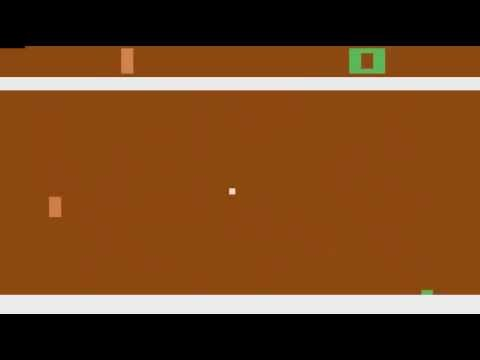

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("p88R2_3yWPA")

In [0]:
YouTubeVideo("TmPfTpjtdgg")

# <a id="sec7"></a>Going further

A lot of contributions have built on the initial success of DQN. Among those, some are combined and discussed in the **[Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)** paper. We will simply summarize their key ideas here, by decreasing order of importance (according to the paper).

- N-step returns. Use samples that accumulate several returns rather than the 1-step return of TD(0).
- [Prioritized experience replay](https://arxiv.org/abs/1511.05952). Inspired by the model-based Prioritized Sweeping approach, bias the distribution used to sample mini-batches in order to present high residual samples to the optimizer. This accelerates the convergence in $L_\infty$ norm.
- [Distributional value functions](https://arxiv.org/abs/1707.06887). Instead of estimating $\mathbb{E}(\sum_t r_t)$, estimate the distribution of $\sum_t r_t$ and iterate on it.
- [NoisyNet](https://arxiv.org/abs/1706.10295). Instead of an $\epsilon$-greedy exploration strategy, introduce noise in the network's parameters to drive the exploration.
- [Dueling architecture](https://arxiv.org/abs/1511.06581). The neural network's architecture splits $Q$ into the estimation of a value $V(s)$ and an advantage $A(s,a)$ with shared first layers.
- [Double Q-learning](https://arxiv.org/abs/1509.06461). Q-learning is prone to over-estimation of the true optimal Q function (especially in high variance environments). Double Q-learning aims at compensating this weakness by introducing an under-estimation mechanism based on a second Q function.

Beyond these improvements, new work is published each year that lead to better understanding of the interplay between Deep Learning and RL.